In [2]:
import torch
import pyro
import matplotlib.pyplot as plt

Suppose a Normal-Inverse Gamma prior on the mean and covariance matrix $\mu, \sigma^2 \sim NIGamma(\mu_0, \lambda, \alpha, \beta)$

In [3]:
### Prior parameters
mu_0 = 0.
lbda = 1.
alpha = 1.
beta = 1.

We will now generate observed data $x_1, ..., x_N \sim N(\mu, \sigma^2)$ for some unknown values of $\mu, \sigma^2$ obtained from the prior.

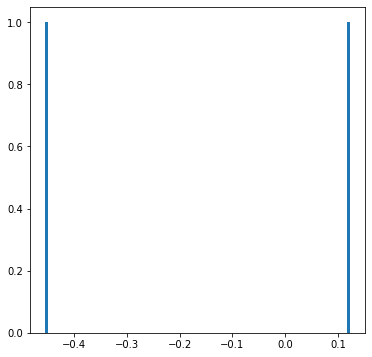

true_sigma_2 = tensor(0.3683)
true_mean = tensor(0.0396)


In [4]:
true_sigma_2 = pyro.distributions.InverseGamma(alpha, beta).sample()
true_mean = torch.distributions.Normal(mu_0,torch.sqrt(true_sigma_2/lbda)).sample()
N = 2
x_N  = torch.distributions.Normal(true_mean, torch.sqrt(true_sigma_2)).sample([N])

import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))
plt.hist(x_N.numpy(), bins = 100)
plt.show()
print('true_sigma_2 = ' + str(true_sigma_2))
print('true_mean = ' + str(true_mean))

Conveniently the Normal-Inverse Gamma is a conjugate prior for the Gaussian Likelihood, such that: 

$\mu, \sigma^2|x_1,..., x_N \sim NIGamma(\mu_N, \lambda_N, \alpha_N, \beta_N)$ where: 

- $\mu_N = \frac{\lambda\mu_0 + N\bar{x}}{\lambda + N}$
- $\lambda_N = \lambda + N$
- $\beta_N = \beta + \frac{1}{2}\sum_{i=1}^N (x_i - \bar{x})^2 + \frac{N\lambda}{2(N+\lambda)}(\bar{x} - \mu_0)^2$
- $\alpha_N = \alpha + N/2$

Since the posterior is also a Normal Inverse Gamma distribution, we can equivalently work on a prior or a posterior. 

In [5]:
lbda_N = lbda + N
alpha_N = alpha + N/2
empirical_mean = torch.mean(x_N, dim =0)
mu_N = (lbda*mu_0 + N*empirical_mean)/lbda_N
beta_N = beta + torch.sum(torch.square(x_N-empirical_mean)).squeeze(-1)/2 + (lbda*N*(empirical_mean-mu_0)**2)/(2*lbda_N)

So we can sample the posterior distribution directly: 

In [6]:
estimated_sigma_2 = pyro.distributions.InverseGamma(alpha_N, beta_N).sample()
estimated_mean = torch.distributions.Normal(mu_N,torch.sqrt(estimated_sigma_2/lbda_N)).sample()

Alternatively, we can sample the posterior via a Gibbs sampling scheme. Indeed both conditionals of a Normal inverse Gamma are available: 
- $\mu|\sigma^2 \sim N(\mu_0, \frac{\sigma^2}{\lambda})$
- $\sigma^2|\mu \sim IGamma(\alpha + \frac{1}{2}, \beta + \frac{\lambda}{2}(\mu-\mu_0)^2)$

In [7]:
#Standard gibbs
list_mean_1 = []
list_sigma_2_1 = []
estimated_sigma_2 = torch.tensor(1.)
for i in range(2000):
    estimated_mean = torch.distributions.Normal(mu_N,torch.sqrt(estimated_sigma_2/lbda_N)).sample()
    alpha_N_tilde = alpha_N + 1/2
    beta_N_tilde = beta_N + lbda_N*((estimated_mean - mu_N)**2)/2
    estimated_sigma_2 = pyro.distributions.InverseGamma(alpha_N_tilde, beta_N_tilde).sample()
    list_mean_1.append(estimated_mean)
    list_sigma_2_1.append(estimated_sigma_2)
chain_values = torch.cat([torch.stack(list_mean_1).unsqueeze(0)], dim = 0)
ess = pyro.ops.stats.effective_sample_size(chain_values, chain_dim = 0, sample_dim = 1)
print(ess)

tensor(2145.0901)


I want to write another transition scheme which extends the Gibbs.

Suppose I target $p(a,b)$ such that both conditionals can be sampled from effortlessly (possibly with conjugacy). Then one can write a Gibbs sampling scheme with iterating over $t$: 
- $a_t \sim p(a|b_{t-1})$
- $b_t \sim p(b|a_t)$

Suppose now that one can also sample effortlessly the conditional of $b$ given several observations of $a$ (we see that it is for example the case in the Normal Inverse Gamma). This leads to the algorithm: 
- $a^{(1)}_t,..., a^{(M)}_t \sim_{iid} p(a|b_{t-1})$ 
- $b_t\sim p(b|a^{(1)}_t,..., a^{(M)}_t)$

Of course in the case $M=1$, we retrieve the usual Gibbs sampler. 


Application to the Normal Inverse Gamma: one can express the conditional of $\sigma^2$ given a bunch of means with conjugacy. 
- $\sigma^2|\mu_1,..., \mu_M \sim IGamma(\alpha + \frac{M}{2}, \beta + \frac{\lambda}{2}\sum_{m=1}^M(\mu_m-\mu_0)^2)$

In [8]:
list_mean_2 = []
list_sigma_2_2 = []
M = 10
estimated_sigma_2 = torch.tensor(1.)
for i in range(2000):
    estimated_mean = torch.distributions.Normal(mu_N,torch.sqrt(estimated_sigma_2/lbda_N)).sample([M])
    alpha_N_tilde = alpha_N + M/2
    beta_N_tilde = beta_N + lbda_N*torch.sum((estimated_mean - mu_N)**2)/2
    estimated_sigma_2 = pyro.distributions.InverseGamma(alpha_N_tilde, beta_N_tilde).sample()
    list_mean_2.append(estimated_mean[0])
    list_sigma_2_2.append(estimated_sigma_2)
chain_values = torch.stack(list_sigma_2_2).unsqueeze(0)
print(chain_values.shape)
ess = pyro.ops.stats.effective_sample_size(chain_values, chain_dim = 0, sample_dim = 1)
print(ess)

torch.Size([1, 2000])
tensor(282.8457)


We see that both algorithms produce samples which appear to be from the same posterior (we check by plotting histogram against marginals): 
- $\sigma^2 \sim IGamma(\alpha, \beta)$
- $\mu \sim T_{2\alpha}(\mu, \sqrt{\frac{\beta}{\lambda\alpha}})$

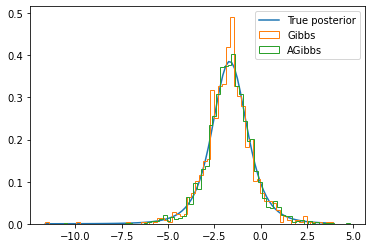

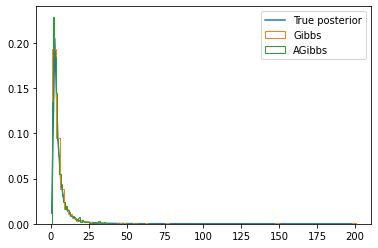

In [54]:
tt = torch.linspace(torch.min(torch.stack(list_mean_1)), torch.max(torch.stack(list_mean_1)), 100)
plt.plot(tt, torch.exp(torch.distributions.StudentT(2*alpha_N, loc= mu_N, scale = torch.sqrt(beta_N/(lbda_N*alpha_N))).log_prob(tt.unsqueeze(-1))), label = 'True posterior')
plt.hist(torch.stack(list_mean_1).numpy(),bins = 75, fill = False, histtype= 'step', density = True, label = 'Gibbs')
plt.hist(torch.stack(list_mean_2).numpy(),bins = 75, fill = False, histtype= 'step', density = True, label = 'AGibbs')
plt.legend()
plt.show()
tt = torch.linspace(torch.min(torch.stack(list_sigma_2_1)), torch.max(torch.stack(list_sigma_2_1)), 100)
plt.plot(tt, torch.exp(pyro.distributions.InverseGamma(alpha_N, beta_N).log_prob(tt.unsqueeze(-1))), label = 'True posterior')
plt.hist(torch.stack(list_sigma_2_1).numpy(),bins = 75, fill = False, histtype= 'step', density = True, label = 'Gibbs')
plt.hist(torch.stack(list_sigma_2_2).numpy(),bins = 75, fill = False, histtype= 'step', density = True, label = 'AGibbs')
plt.legend()
plt.show()